# Belgian Load Forecasting
Gian Marco PALDINO, Pascal TRIBEL
## 1. Preprocessing

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from datetime import datetime

### Data reading

In [42]:
filepath = "./data/ods0001_d18032025.csv"
data = pd.read_csv(filepath, delimiter=";", index_col='Datetime')[::-1]
data.index = pd.to_datetime(data.index, errors='coerce', utc=True)

The data is sampled with a temporal granularity of 15 minutes: the resolution code column does not bring additionnal information. We discard it:

In [43]:
data = data.drop(columns = ["Resolution code"])

We process the timestamps. The datetime is set to `UTC+0` values, and the year, month, day, hour, minutes and season is extracted from the timestamps:

In [44]:
data["Year"] = [i.year for i in data.index]
data["Month"] = [i.month for i in data.index]
data["Day"] = [i.day for i in data.index]
data["Hour"] = [i.hour for i in data.index]
data["Minute"] = [i.minute for i in data.index]
data["Season"] = data["Month"]//4

Belgium has experienced the COVID lockdown:
- Between the 18/3/2020 and the 3/5/2020
- Between the 2/11/2020 and the 1/4/2021

<a href="https://fr.wikipedia.org/wiki/Pandémie_de_Covid-19_en_Belgique">Wikipedia page of the Belgian COVID crisis</a>

In [45]:
data["Lockdown"] = 0
data.iloc[182692:187181, data.columns.get_loc("Lockdown")] = 1
data.iloc[204772:219268, data.columns.get_loc("Lockdown")] = 1

We interpolate linearly the Total Load to impute missing values:

In [46]:
data['Total Load Interpolated'] = data['Total Load'].interpolate(method='linear')

In [15]:
data.head()

,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Year,Month,Day,Hour,Minute,Season,Lockdown,Total Load Interpolated
Datetime,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,10142.19,9496.05,8871.71,10120.38,9697.59,9076.64,10318.53,9833.37,2014,12,31,23,0,3,0,10142.19
2014-12-31 23:15:00+00:00,10051.28,9329.17,8715.80,9942.53,9526.54,8916.55,10136.53,9653.31,2014,12,31,23,15,3,0,10051.28
2014-12-31 23:30:00+00:00,9952.87,9174.72,8571.51,9777.92,9367.66,8767.84,9967.47,9473.22,2014,12,31,23,30,3,0,9952.87
2014-12-31 23:45:00+00:00,9821.78,9025.46,8432.07,9618.85,9216.09,8625.97,9806.20,9319.45,2014,12,31,23,45,3,0,9821.78
2015-01-01 00:00:00+00:00,9755.00,9222.33,8880.23,9564.44,10130.36,9777.87,10482.86,9203.25,2015,1,1,0,0,0,0,9755.00


We define the mean absolute percentage error as
\begin{equation}
    MAPE(y, \hat{y}) = \frac{100}{n}\sum^n\frac{y-\hat{y}}{y}
\end{equation}

In [47]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Here is an example of the most recent forecasting provided by ELIA, compared to the ground truth:

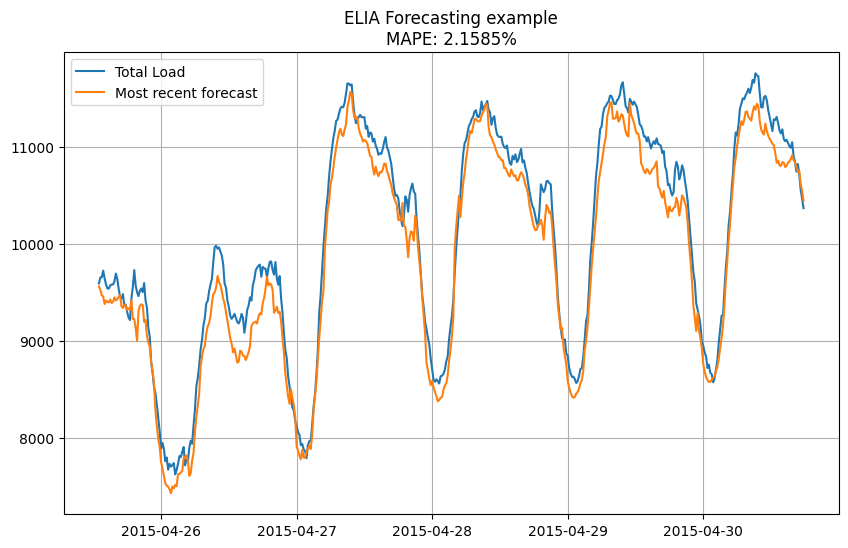

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(data.index[11000:11500], data["Total Load"][11000:11500], label="Total Load")
plt.plot(data.index[11000:11500], data["Most recent forecast"][11000:11500], label="Most recent forecast")
plt.title(f"ELIA Forecasting example\nMAPE: {mape(data['Total Load'][11000:11500], data['Most recent forecast'][11000:11500]):.4f}%")
plt.legend()
plt.grid()
plt.show()

We save the data to a csv:

In [18]:
data.to_csv("data/preprocessed_data_18032025.csv")

In [20]:
data

,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Year,Month,Day,Hour,Minute,Season,Lockdown,Total Load Interpolated,Previous_24h_before
Datetime,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,10142.19,9496.05,8871.71,10120.38,9697.59,9076.64,10318.53,9833.37,2014,12,31,23,0,3,0,10142.19,0
2014-12-31 23:15:00+00:00,10051.28,9329.17,8715.80,9942.53,9526.54,8916.55,10136.53,9653.31,2014,12,31,23,15,3,0,10051.28,0
2014-12-31 23:30:00+00:00,9952.87,9174.72,8571.51,9777.92,9367.66,8767.84,9967.47,9473.22,2014,12,31,23,30,3,0,9952.87,0
2014-12-31 23:45:00+00:00,9821.78,9025.46,8432.07,9618.85,9216.09,8625.97,9806.20,9319.45,2014,12,31,23,45,3,0,9821.78,0
2015-01-01 00:00:00+00:00,9755.00,9222.33,8880.23,9564.44,10130.36,9777.87,10482.86,9203.25,2015,1,1,0,0,0,0,9755.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25 21:45:00+00:00,NaN,9185.85,8769.06,9602.65,9185.85,8769.06,9602.65,9185.85,2025,3,25,21,45,0,0,10700.04,0
2025-03-25 22:00:00+00:00,NaN,9069.36,8642.64,9496.08,9069.36,8642.64,9496.08,9069.36,2025,3,25,22,0,0,0,10700.04,0
2025-03-25 22:15:00+00:00,NaN,8956.48,8535.07,9377.89,8956.48,8535.07,9377.89,8956.48,2025,3,25,22,15,0,0,10700.04,0


In [55]:
# Add new feature: load of the previous day and previous week

data["Previous_24h"] = .0
data["Previous_7days"] = .0
data.iloc[(24*4):, data.columns.get_loc("Previous_24h")] = data.iloc[:-(24*4), data.columns.get_loc("Total Load Interpolated")]
data.iloc[(7*24*4):, data.columns.get_loc("Previous_7days")] = data.iloc[:-(7*24*4), data.columns.get_loc("Total Load Interpolated")]

In [51]:
data

,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Year,Month,Day,Hour,Minute,Season,Lockdown,Total Load Interpolated,Previous_24h,Previous_7days
Datetime,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,10142.19,9496.05,8871.71,10120.38,9697.59,9076.64,10318.53,9833.37,2014,12,31,23,0,3,0,10142.19,0.00,0.00
2014-12-31 23:15:00+00:00,10051.28,9329.17,8715.80,9942.53,9526.54,8916.55,10136.53,9653.31,2014,12,31,23,15,3,0,10051.28,0.00,0.00
2014-12-31 23:30:00+00:00,9952.87,9174.72,8571.51,9777.92,9367.66,8767.84,9967.47,9473.22,2014,12,31,23,30,3,0,9952.87,0.00,0.00
2014-12-31 23:45:00+00:00,9821.78,9025.46,8432.07,9618.85,9216.09,8625.97,9806.20,9319.45,2014,12,31,23,45,3,0,9821.78,0.00,0.00
2015-01-01 00:00:00+00:00,9755.00,9222.33,8880.23,9564.44,10130.36,9777.87,10482.86,9203.25,2015,1,1,0,0,0,0,9755.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25 21:45:00+00:00,NaN,9185.85,8769.06,9602.65,9185.85,8769.06,9602.65,9185.85,2025,3,25,21,45,0,0,10700.04,10700.04,10700.04
2025-03-25 22:00:00+00:00,NaN,9069.36,8642.64,9496.08,9069.36,8642.64,9496.08,9069.36,2025,3,25,22,0,0,0,10700.04,10700.04,10700.04
2025-03-25 22:15:00+00:00,NaN,8956.48,8535.07,9377.89,8956.48,8535.07,9377.89,8956.48,2025,3,25,22,15,0,0,10700.04,10700.04,10700.04


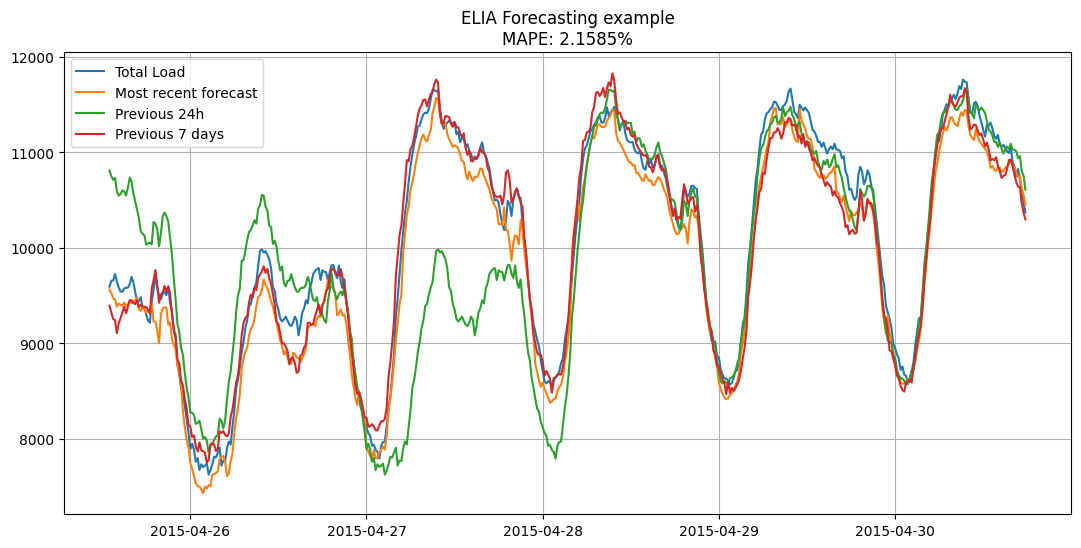

In [53]:
plt.figure(figsize=(13, 6))
plt.plot(data.index[11000:11500], data["Total Load"][11000:11500], label="Total Load")
plt.plot(data.index[11000:11500], data["Most recent forecast"][11000:11500], label="Most recent forecast")
plt.plot(data.index[11000:11500], data["Previous_24h"][11000:11500], label="Previous 24h")
plt.plot(data.index[11000:11500], data["Previous_7days"][11000:11500], label="Previous 7 days")
plt.title(f"ELIA Forecasting example\nMAPE: {mape(data['Total Load'][11000:11500], data['Most recent forecast'][11000:11500]):.4f}%")
plt.legend()
plt.grid()
plt.show()

In [56]:
# Save the new data. Do not include the first week

data.iloc[(7*24*4):, :].to_csv("data/preprocessed_data_multimodality_18032025.csv")